## 1. 데이터 불러오기

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
df = pd.read_csv('~/aiffel/sentiment_classification/data/ratings_train.txt',sep="	",header=None)
df

,0,1,2
0,id,document,label
1,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
2,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
3,10265843,너무재밓었다그래서보는것을추천한다,0
4,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
...,...,...,...
149996,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149997,8549745,평점이 너무 낮아서...,1
149998,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149999,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       150001 non-null  object
 1   1       149996 non-null  object
 2   2       150001 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB


training data의 document에서 결측치 관찰됨

In [4]:
f = pd.read_csv('~/aiffel/sentiment_classification/data/ratings_test.txt',sep="	",header=None)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       50001 non-null  object
 1   1       49998 non-null  object
 2   2       50001 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


test data의 document에서 결측치 관찰됨

In [5]:
k = df[df[[1]].isnull().any(axis=1)].head(15)
k

,0,1,2
25858,2172111,NaN,1
55738,6369843,NaN,1
110015,1034280,NaN,0
126783,5942978,NaN,0
140722,1034283,NaN,0


In [6]:
a_train = [index-1 for index in k.index] #데이터 프레임 적용된 상태에서 인덱스가 1 늘어났기 때문에 원본 데이터와 맞쳐줌
a_train

[25857, 55737, 110014, 126782, 140721]

In [7]:
k_te = f[f[[1]].isnull().any(axis=1)].head(15)
k_te

,0,1,2
5747,402110,NaN,1
7900,5026896,NaN,0
27098,511097,NaN,1


In [8]:
a_test = [index-1 for index in k_te.index] #데이터 프레임 적용된 상태에서 인덱스가 1 늘어났기 때문에 원본 데이터와 맞쳐줌
a_test

[5746, 7899, 27097]

## 2. 데이터 전처리
불용어, 결측치, 토큰화, 중복제거 등 시행

In [9]:
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
"""
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    def nrmz(dataset): 

        dataset.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
        dataset['document'] = dataset['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
        dataset['document'] = dataset['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
        dataset['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
        dataset = dataset.dropna(how='any') # Null 값 제거
        
    nrmz(train_data)
    nrmz(test_data)
    
    #형태소 분석기를 통한 불용어 처리
    okt = Okt()
    X_train = []
    for sentence in tqdm(train_data['document']):
        tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X_train.append(stopwords_removed_sentence)
        
    X_test = []
    for sentence in tqdm(test_data['document']):
        tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X_test.append(stopwords_removed_sentence)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
"""

'\ndef load_data(train_data, test_data, num_words=10000):\n    train_data.drop_duplicates(subset=[\'document\'], inplace=True)\n    train_data = train_data.dropna(how = \'any\') \n    test_data.drop_duplicates(subset=[\'document\'], inplace=True)\n    test_data = test_data.dropna(how = \'any\') \n    \n    def nrmz(dataset): \n\n        dataset.drop_duplicates(subset = [\'document\'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거\n        dataset[\'document\'] = dataset[\'document\'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행\n        dataset[\'document\'] = dataset[\'document\'].str.replace(\'^ +\', "") # 공백은 empty 값으로 변경\n        dataset[\'document\'].replace(\'\', np.nan, inplace=True) # 공백은 Null 값으로 변경\n        dataset = dataset.dropna(how=\'any\') # Null 값 제거\n        \n    nrmz(train_data)\n    nrmz(test_data)\n    \n    #형태소 분석기를 통한 불용어 처리\n    okt = Okt()\n    X_train = []\n    for sentence in tqdm(train_data[\'document\']):\n        tokenized_sentence = okt.morphs(sentence, 

In [11]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 1.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  35
전체 문장의 0.9108268190171958%가 maxlen 설정값 이내에 포함됩니다. 


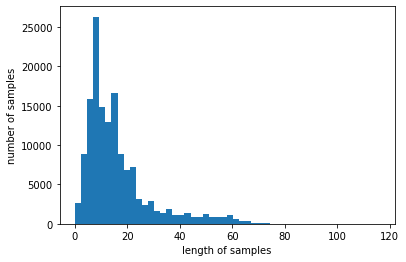

In [15]:
import matplotlib.pyplot as plt
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

우선 문장 최대 길이를 (평균 + 1.5 * std)로 지정
그래프 상으로 20이 넘어가는 시점부터 샘플 수가 급격히 줄어드는 것을 볼 수 있음

In [16]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 35)


## 모델 생성

In [61]:
from tensorflow.keras.initializers import Constant

vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 35  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(256, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

ValueError: Negative dimension size caused by subtracting 7 from 5 for '{{node conv1d_16/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_16/conv1d/ExpandDims, conv1d_16/conv1d/ExpandDims_1)' with input shapes: [?,1,5,256], [1,7,256,16].

In [58]:
print(X_train.shape)

(146182, 35)


In [56]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

In [44]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

In [46]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']

KeyError: 4

## 학습 시키기

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:1131 convolution_v2
        return convolution_internal(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:1261 convolution_internal
        return op(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:617 new_func
        return func(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:617 new_func
        return func(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:2003 conv1d
        result = gen_nn_ops.conv2d(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py:969 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 7 from 5 for '{{node sequential_8/conv1d_14/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_8/conv1d_14/conv1d/ExpandDims, sequential_8/conv1d_14/conv1d/ExpandDims_1)' with input shapes: [?,1,5,256], [1,7,256,16].
